In [1]:
from collections import Counter

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
movie_data = pd.read_csv(r'data/movie_metadata.csv')
#movie_data = movie_data.replace('', np.nan)

# Data Wrangling

1. Column analysis
2. Key value: IMDB_id
3. Fill NaN values with other datasets
4. Filling or Removing Nan Values
5. Additional Data Preperation

### 1) Columns analysis:
    - color
    - year
    - aspect ratio

We check what columns are actually useful and we analyze these three, which must be edited.

In [3]:
print("The features of the movie datase are:")
print(movie_data.dtypes)

The features of the movie datase are:
color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64


**Color**

We check that the color column is binary: a film is 'black and white' or is 'color'. Then, we drop the color column, because we want to help a modern film company and it is gonna make color films quite surely. 

In fact, in the next cells we are gonna keep only movies produced after the 1980. Most of them are 'Color'.

In [4]:
colors = movie_data.color.unique() # values in the column color
color_values = [x for x in colors if str(x) != 'nan']# drop nan
#color_values[1] = color_values[1].strip() # delete spaces before 'black'
print(f"The color column has only {len(color_values)} different values: '{color_values[0]}' and '{color_values[1]}'.")

The color column has only 2 different values: 'Color' and ' Black and White'.


In [5]:
# dataframe years and colors:
year_color = movie_data[['color', 'title_year']] # we only need color and year
year_color = year_color[~year_color.color.isnull()] # deletete color NaN values 
year_color = year_color[~year_color.title_year.isnull()]  # deletete title NaN values 
year_color = year_color.sort_values('title_year') # sort by year

years = year_color.title_year.drop_duplicates().tolist() # years
n_years = len(years)

for i in range(n_years): 
    year = int(years[i]) # year
    year_movies = year_color.loc[year_color['title_year'] == years[i]].color.values # all colors of film of that year
    
    # number black and white and color movies for each year
    num_c = (year_movies == color_values[0]).sum()
    num_bw = (year_movies == color_values[1]).sum()
    
    # dataframe: for each row year, num colors, num blackwhite
    d = {'year':year , 'num_color':num_c , 'num_black_white':num_bw }
    
    if i==0 :
        year_number_colors = pd.DataFrame( data = d , index = [year] )
    else: 
        #year_number_colors = pd.concat(d, ignore_index=True)
        d2 = pd.DataFrame( data = d , index = [year])
        year_number_colors = year_number_colors.append(d2, ignore_index=True)
        
print("For each year, we check how many films are colored and how many black and white:")
year_number_colors = year_number_colors.set_index('year')
year_number_colors.head()

For each year, we check how many films are colored and how many black and white:


,num_color,num_black_white
year,,
1916,0,1
1920,0,1
1925,0,1
1927,0,1
1929,0,2


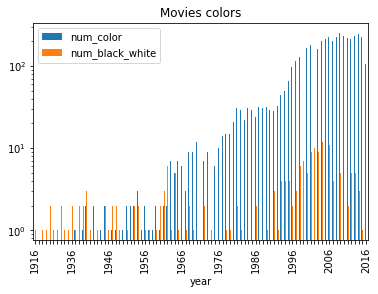

In [6]:
year_number_colors['year']=year_number_colors.index
f=year_number_colors.plot(x="year", y=["num_color", "num_black_white"], kind="bar")
plt.yscale('log', nonposy='clip')
plt.title("Movies colors")
for ind, label in enumerate(f.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
#f.set_yscale("log")

We can see that most of movies in recent years are color, so this column is not a relevant feature. We can drop it

In [7]:
movie_data = movie_data.drop('color', axis=1) # drop color column

**Year**

Custumers' tastes change really fastly. We have already decided to drop black and white films, because they are not relevant for the analysis. In the same way, we can ignore films which were produced before 1980. As it can be seen in this histogram, this choice does not drop the majority of the movies, which were produced after 1980.

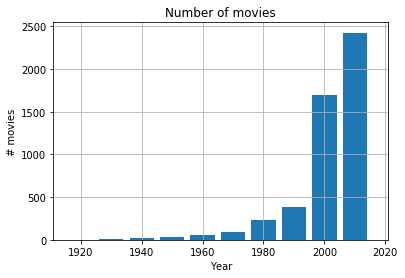

In [8]:
movie_data.title_year.hist( histtype='bar', width = 8)
plt.title("Number of movies")
plt.ylabel("# movies")
plt.xlabel("Year")
plt.show()

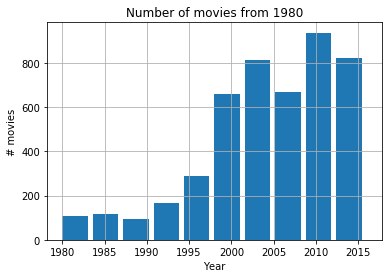

In [9]:
movie_data = movie_data[movie_data.title_year>=1980] # drop film before 1980
movie_data.title_year.hist(width = 3)
plt.title("Number of movies from 1980")
plt.ylabel("# movies")
plt.xlabel("Year")
plt.show()

**Aspect Ratio**

We want to anlyse if the aspect ratio is an intresting feature. Nowadays, there are some rules which says the ratio that film-makers must use (we cans earch something online). In order to do that we investigate for each year what aspect ratios were used. ù

For example wikipedia says (https://en.wikipedia.org/wiki/Aspect_ratio_(image)) :

The most common aspect ratios used today in the presentation of films in cinemas are 1.85:1 and 2.39:1.[2] Two common videographic aspect ratios are 4:3 (1.3:1),[a] the universal video format of the 20th century, and 16:9 (1.7:1), universal for high-definition television and European digital television. Other cinema and video aspect ratios exist, but are used infrequently.

In [10]:
ar = movie_data.aspect_ratio.unique() 
ar = [x for x in ar if str(x) != 'nan'] # drop nan
ar = sorted(ar) # sort 
print("The aspect ratios which were used were:")
print(*ar, sep = "\n")

The aspect ratios which were used were:
1.18
1.33
1.37
1.44
1.5
1.66
1.75
1.77
1.78
1.85
1.89
2.0
2.2
2.24
2.35
2.39
2.4
2.55
2.76
16.0


In [11]:
# dataframe years and aspect ratio:
year_ar = movie_data[['title_year', 'aspect_ratio']] # we only need color and year
year_ar = year_ar[~year_ar.aspect_ratio.isnull()] # deletete color NaN values 
year_ar = year_ar[~year_ar.title_year.isnull()]  # deletete title NaN values 
year_ar = year_ar.sort_values('title_year') # sort by year

years = year_ar.title_year.drop_duplicates().tolist() # years
n_years = len(years)

for i in range(n_years):  
    year = int(years[i]) # year
    year_movies = year_ar.loc[year_ar['title_year'] == years[i]].aspect_ratio.values # all colors of film of that year
    
    # number of each of the aspect ratios
    num = [] 
    for j in range(len(ar)): # for each aspect ratio
        sum_ar = (year_movies == ar[j]).sum()
        num.append(sum_ar) 
    
    # dataframe: for each row year, num of each aspect ratio
    d = dict(zip(ar, num)) # dictionary to create the dataframe
    
    d['year'] = year
    
    if i==0 :
        year_number_ar = pd.DataFrame( data = d , index = [year] )
    else: 
        #year_number_colors = pd.concat(d, ignore_index=True)
        d2 = pd.DataFrame( data = d , index = [year])
        year_number_ar = year_number_ar.append(d2, ignore_index=True)
        
print("For each year, we check the number of films:")
#year_number_ar = year_number_ar.set_index('year')
year_number_ar.head()

For each year, we check the number of films:


,1.18,1.33,1.37,1.44,1.5,1.66,1.75,1.77,1.78,1.85,...,2.0,2.2,2.24,2.35,2.39,2.4,2.55,2.76,16.0,year
0,0,0,1,0,0,0,0,0,0,11,...,0,0,0,12,0,0,0,0,0,1980
1,0,0,2,0,0,0,0,0,1,15,...,0,0,0,15,0,0,0,0,0,1981
2,0,0,0,0,0,0,0,0,0,12,...,0,0,0,16,0,0,0,0,0,1982
3,0,0,0,0,0,0,0,0,0,12,...,0,0,0,8,0,0,0,0,0,1983
4,0,0,0,0,0,0,0,0,0,21,...,0,1,0,9,0,0,0,0,0,1984


From this Data Frame we can see that 1.85 and 2.35 have way more movies than all the others ratios. We can plot these two and the sum of all the other and see that the other are irrelevant.

In [12]:
#we sum all the other columns: 

year_number_ar['sum'] =  year_number_ar[year_number_ar.columns[0]]
lista = [1,2,3,4,5,6,7,8,10,11,12,13,15,16,17,18,19]

for i in range(len(lista)):
    index = lista[i]
    year_number_ar['sum'] = year_number_ar['sum'] + year_number_ar[year_number_ar.columns[index]]

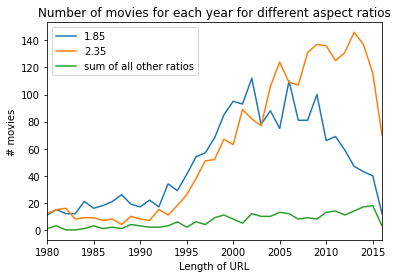

In [13]:
# plot:
# identification of the columns
ar_185 = year_number_ar.columns[9]
ar_235 = year_number_ar.columns[14]
ar_sum = year_number_ar.columns[21]


year_number_ar.plot(kind='line',x='year', y=[ar_185,ar_235, ar_sum])

plt.legend(loc='upper right')
plt.xlabel('Length of URL')

plt.ylabel('# movies')
plt.legend(['1.85','2.35','sum of all other ratios'])
plt.title("Number of movies for each year for different aspect ratios")
plt.show()

This plot shows that in the last years most of the movies use only two aspect ratios. So, it is not a intresting feature: probablu there is some obbligation and our film company should not use this characteristic to decide the next investment. 
    
In particulare, we see a drop in the orange line after 2012. This does not mean that the customers prefer other aspect ratio. This is due to a geenral drop in film production. In fact, also other lines goes down. To show this we can use percentage:


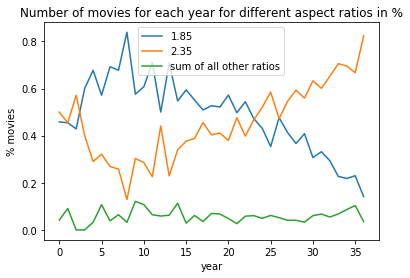

In [14]:
ar_185_perc = year_number_ar[year_number_ar.columns[9]].values
ar_235_perc = year_number_ar[year_number_ar.columns[14]].values
ar_sum_perc = year_number_ar[year_number_ar.columns[21]].values
at_tot = ar_185_perc + ar_235_perc + ar_sum_perc
years = year_number_ar.index.values


plt.plot(years,ar_185_perc/at_tot)
plt.plot(years,ar_235_perc/at_tot)
plt.plot(years,ar_sum_perc/at_tot)
plt.xlabel('year')
plt.ylabel('% movies')
plt.legend(['1.85','2.35','sum of all other ratios'])
plt.title("Number of movies for each year for different aspect ratios in %")
plt.show()

We will analize the general drop of number of films and possible reasons. Here we want to focus only on aspect ratio. In conclusion, we can drop this column. 

In [15]:
movie_data = movie_data.drop('aspect_ratio', axis=1) # drop aspect ratio column

### 2) Key value: IMDB_id

From the movie_imdb_link we extract the IMDB_id. It is useful to match this database with the another one, that we need to fill the NaN values. The reason why we do not use the title to match them is that the title is not an unique key: it can be inconsistent between different data sets (eg Capitalization). 
We check that this 'imdb_id' is unique and we set it as index 

In [16]:
# extraction of imdb_id 
movie_data['imdb_id'] = movie_data.movie_imdb_link.str.split('/').map(lambda row: row[4])
if movie_data.imdb_id.nunique() == len(movie_data.imdb_id): 
    movie_data = movie_data.set_index(imdb_id) # add imdb_id as a new column

movie_data = movie_data.drop('movie_imdb_link', axis=1) # drop link column
    
movie_data.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,imdb_id
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,33000,tt0499549
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,0,tt0449088
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,85000,tt2379713
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,164000,tt1345836
5,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,24000,tt0401729


Now, we cannot just set imdb_id as index: this is not an unique key right now. Before that, we have to delete duplicate rows. 

This is also the first step for the deletion of NaN values. In fact, a lot of NaN values derive from the fact that if a film is present twice, and not both lines have all the values.

In [17]:
print("Number of NaN values for each feature before dropping doplicate rows:")
movie_data.isna().sum()

Number of NaN values for each feature before dropping doplicate rows:


director_name                  0
num_critic_for_reviews        41
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        619
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                140
num_user_for_reviews          15
language                       5
country                        1
content_rating               255
budget                       375
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
imdb_id                        0
dtype: int64

From the DataFrame we delete duplicates movies. In order to do that, we sort our value for the number of NaN and we keep only the copy with the lower number of features with value NaN. 
This should not only delete duplicates, but also reduce the number of NaN for each feature.

In [18]:
movie_data = (
    movie_data.iloc[movie_data.isnull().sum(axis=1).mul(-1).argsort()] # Sort by number of NaN
        .drop_duplicates(subset='imdb_id', keep='last') # Remove duplicates taking last element
)

print("Number of NaN values for each feature after dropping doplicate rows:")
movie_data.isna().sum()

Number of NaN values for each feature after dropping doplicate rows:


director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        604
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       369
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
imdb_id                        0
dtype: int64

 A lot of features have less missing values. This makes our DataFrame more consistent. 
Moreover, now we have an unique key: imdb_id. Now, we can set it as index.

In [19]:
movie_data = movie_data.set_index('imdb_id') # set index
movie_data.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt2638024,Amal Al-Agroobi,NaN,62.0,58.0,NaN,NaN,NaN,NaN,Documentary|Family,NaN,...,autism|middle east|music therapy|united arab e...,NaN,Arabic,United Arab Emirates,NaN,125000.0,2013.0,NaN,8.2,54
tt0304692,Harry Gantz,12.0,105.0,0.0,NaN,NaN,NaN,247740.0,Documentary|Drama,NaN,...,bisexual|explicit sex|sex|stranger|swing,8.0,English,USA,NaN,NaN,2002.0,NaN,4.7,51
tt0488873,Andrew Berends,12.0,90.0,0.0,NaN,NaN,NaN,NaN,Documentary|War,NaN,...,american|blood|dream|patrol|tank,7.0,English,USA,NaN,120000.0,2005.0,NaN,6.6,14
tt4462082,Jem Cohen,12.0,111.0,6.0,NaN,NaN,NaN,NaN,Documentary,NaN,...,city|city symphony|diary|essay|surveillance,1.0,English,USA,NaN,50000.0,2015.0,NaN,6.0,5
tt4607906,Valentine,NaN,NaN,0.0,NaN,Valentine,17.0,NaN,Romance,Diane Sorrentino,...,NaN,NaN,English,USA,PG-13,125000.0,2015.0,0.0,5.1,0


### 3) Fill NaN values with other datasets:
 - Wikipedia dataset
 - TMDb dataset

In [20]:
movie_data.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        604
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       369
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

**Wikipedia**

This is the Wikipedia query that we used to download data:

```
SELECT ?movieLabel (MAX(?grosses) as ?gross) (MIN(?costs) as ?cost) (MIN(?publicationYears) as ?publicationYear) ?IMDBid
WHERE 
{
  ?movie (wdt:P31/wdt:P279*) wd:Q11424;
                             wdt:P345 ?IMDBid;
                             wdt:P2142 ?grosses;
                             wdt:P577 ?publicationDate.
  
  OPTIONAL {?movie wdt:P2130 ?costs.}
  
  BIND(YEAR(?publicationDate) AS ?publicationYears)
  
  FILTER(?publicationYears >= (1980))
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
} GROUP BY ?movieLabel ?IMDBid
```

In [21]:
wiki_data = pd.read_csv('data/wiki_data.csv').drop('movieLabel', axis=1).set_index("IMDBid") # read data from the wiki_data csv
wiki_data = wiki_data.rename(columns={"gross":"gross_1"}) #rename gross column
wiki_data = wiki_data.sort_values(axis=0, by="IMDBid")
wiki_data.head()

,gross_1,cost,publicationYear
IMDBid,,,
tt0074486,7000000.0,100000.0,1980
tt0076709,1950391.0,NaN,1981
tt0078788,83471511.0,31500000.0,2019
tt0079417,106000000.0,NaN,1980
tt0080339,83453539.0,3500000.0,1980


In [22]:
# merge the two dataset on the imdb_id
movie_df = movie_data.merge(wiki_data, how='left', left_index=True, right_index=True)

In [23]:
movie_df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,gross_1,cost,publicationYear
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt2638024,Amal Al-Agroobi,NaN,62.0,58.0,NaN,NaN,NaN,NaN,Documentary|Family,NaN,...,United Arab Emirates,NaN,125000.0,2013.0,NaN,8.2,54,NaN,NaN,NaN
tt0304692,Harry Gantz,12.0,105.0,0.0,NaN,NaN,NaN,247740.0,Documentary|Drama,NaN,...,USA,NaN,NaN,2002.0,NaN,4.7,51,NaN,NaN,NaN
tt0488873,Andrew Berends,12.0,90.0,0.0,NaN,NaN,NaN,NaN,Documentary|War,NaN,...,USA,NaN,120000.0,2005.0,NaN,6.6,14,NaN,NaN,NaN
tt4462082,Jem Cohen,12.0,111.0,6.0,NaN,NaN,NaN,NaN,Documentary,NaN,...,USA,NaN,50000.0,2015.0,NaN,6.0,5,NaN,NaN,NaN
tt4607906,Valentine,NaN,NaN,0.0,NaN,Valentine,17.0,NaN,Romance,Diane Sorrentino,...,USA,PG-13,125000.0,2015.0,0.0,5.1,0,NaN,NaN,NaN


In [24]:
movie_data.shape, movie_df.shape

((4560, 25), (4560, 28))

Now we have some repeated columns:
- gross
- costs

We have to keep only one of them. Instead of deleting one without an analysis. we match them in order to delete as many NaN values as possible

- grosses:

In [25]:
# gross :   gross from movie dataset
# gorss_1 : gross from wiki dataset

gross_movie_na = movie_df.gross.isna()

for i in range(len(gross_movie_na)): # for each film
    if gross_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.gross[i] = movie_df.gross_1[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop('gross_1', axis=1) # drop link gross wiki column

- costs:

In [26]:
# budget :   cost from movie dataset
# cost :     cost from wiki dataset

cost_movie_na = movie_df.budget.isna()


for i in range(len(cost_movie_na)): # for each film
    if cost_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.budget[i] = movie_df.cost[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop(['cost','publicationYear'], axis=1) # drop link cost wiki column

Now we can see that the number of movies with empty values in gross and budget has decreased :)

In [27]:
movie_df.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        577
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       359
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

**TMDb**

In [28]:
tmdb_data = pd.read_csv('data/tmdb_movies_data.csv').set_index("imdb_id") # read data from the wiki_data csv
tmdb_data = tmdb_data.rename(columns={"budget":"budget_1"}) #rename gross column
tmdb_data = tmdb_data[['budget_1','revenue','keywords','release_year']]
tmdb_data.head()

,budget_1,revenue,keywords,release_year
imdb_id,,,,
tt0369610,150000000,1513528810,monster|dna|tyrannosaurus rex|velociraptor|island,2015
tt1392190,150000000,378436354,future|chase|post-apocalyptic|dystopia|australia,2015
tt2908446,110000000,295238201,based on novel|revolution|dystopia|sequel|dyst...,2015
tt2488496,200000000,2068178225,android|spaceship|jedi|space opera|3d,2015
tt2820852,190000000,1506249360,car race|speed|revenge|suspense|car,2015


In [29]:
movie_df = movie_df.merge(tmdb_data, how='left', left_index=True, right_index=True)
movie_df = movie_df.drop(['release_year','revenue'], axis=1)
movie_df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,budget_1,keywords
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,Hugh Jackman,...,English,USA,PG-13,48000000.0,2001.0,1000.0,6.4,0,0.0,lover (female)|love of one's life|time travel|...
tt0080339,Jim Abrahams,134.0,88.0,104.0,318.0,Lloyd Bridges,628.0,83400000.0,Comedy,Peter Graves,...,English,USA,PG,3500000.0,1980.0,575.0,7.8,16000,3500000.0,chicago|alcohol|cataclysm|guitar|medicine
tt0080453,Randal Kleiser,36.0,104.0,116.0,83.0,Christopher Atkins,1000.0,58853106.0,Adventure|Drama|Romance,Brooke Shields,...,English,USA,R,4500000.0,1980.0,511.0,5.7,0,4500000.0,sexual identity|shipwreck|lovers|stranded|maro...
tt0080455,John Landis,125.0,148.0,644.0,326.0,Aretha Franklin,1000.0,54200000.0,Action|Comedy|Crime|Music,John Belushi,...,English,USA,R,27000000.0,1980.0,809.0,7.9,14000,27000000.0,dancing|prison|chicago|country music|nun
tt0080487,Harold Ramis,71.0,98.0,11000.0,484.0,Rodney Dangerfield,13000.0,39800000.0,Comedy|Sport,Bill Murray,...,English,USA,R,6000000.0,1980.0,573.0,7.4,0,6000000.0,golf|underwear|sport|golf course|gopher


**budget**

In [30]:
# budget :   cost from movie dataset
# budget_1 :     cost from TDM  dataset

cost_movie_na = movie_df.budget.isna()

for i in range(len(cost_movie_na)): # for each film
    if cost_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.budget[i] = movie_df.budget_1[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop('budget_1', axis=1) # drop link cost wiki column

**keywords**

In [31]:
# plot_keywords :    from movie dataset
# keywords :      from TDM  dataset

keywords_movie_na = movie_df.plot_keywords.isna()

for i in range(len(keywords_movie_na)): # for each film
    if keywords_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.plot_keywords[i] = movie_df.keywords[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop(['keywords'], axis=1) # drop link cost wiki column

In [32]:
movie_df.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        577
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                129
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       171
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

### 4) Filling or Removing NaN Values

In [33]:
movie_df = movie_df.drop(columns=['plot_keywords'])
movie_df = movie_df.dropna(subset=['gross','budget'])

In [34]:
NotFamous = {'actor_2_name': 'No Second Actor', 'actor_1_name': 'No Actor', 'actor_3_name': 'No Third Actor'}
movie_df = movie_df.fillna(value=NotFamous)
NotFBlikes = {'actor_3_facebook_likes': 0, 'actor_2_facebook_likes': 0, 'actor_1_facebook_likes': 0}
movie_df = movie_df.fillna(value=NotFBlikes)
NotRated = {'content_rating': 'Not Rated'}
movie_df = movie_df.fillna(value=NotRated)

In [35]:
movie_df.loc['tt3949660', 'facenumber_in_poster']=4
movie_df.loc['tt0903624', 'facenumber_in_poster']=1
movie_df.loc['tt3567288', 'facenumber_in_poster']=0
movie_df.loc['tt0989757', 'facenumber_in_poster']=2
movie_df.loc['tt1929263', 'facenumber_in_poster']=0
movie_df.loc['tt3014666', 'facenumber_in_poster']=6
movie_df=movie_df.dropna()
movie_df.head()
movie_df=movie_df.replace({'content_rating': {'Unrated': 'Not Rated'}})
movie_df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,facenumber_in_poster,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,Hugh Jackman,...,1.0,316.0,English,USA,PG-13,48000000.0,2001.0,1000.0,6.4,0
tt0080339,Jim Abrahams,134.0,88.0,104.0,318.0,Lloyd Bridges,628.0,83400000.0,Comedy,Peter Graves,...,0.0,427.0,English,USA,PG,3500000.0,1980.0,575.0,7.8,16000
tt0080453,Randal Kleiser,36.0,104.0,116.0,83.0,Christopher Atkins,1000.0,58853106.0,Adventure|Drama|Romance,Brooke Shields,...,0.0,140.0,English,USA,R,4500000.0,1980.0,511.0,5.7,0
tt0080455,John Landis,125.0,148.0,644.0,326.0,Aretha Franklin,1000.0,54200000.0,Action|Comedy|Crime|Music,John Belushi,...,1.0,319.0,English,USA,R,27000000.0,1980.0,809.0,7.9,14000
tt0080487,Harold Ramis,71.0,98.0,11000.0,484.0,Rodney Dangerfield,13000.0,39800000.0,Comedy|Sport,Bill Murray,...,3.0,250.0,English,USA,R,6000000.0,1980.0,573.0,7.4,0


In [36]:
movie_df['budget']=movie_df['budget'].replace(0,'NaN')
movie_df['budget']=movie_df['budget'].replace('NaN',movie_df['budget'].median())

In [37]:
movie_df.isna().sum()

director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
dtype: int64

### 5) Additional Data Preparation

Here, we divided genres column into 9 different groups which we think mostly exist together. Group 9 includes the smaller genres which have small number of movies under them:

1. Group  = Action|Adventure
2. Group  = Comedy
3. Group  = Drama
4. Group  = Mystery|Thriller|Horror
5. Group  = Animation
6. Group  = Crime
7. Group  = Sci-Fi|Superhero|Fantasy
8. Group  = Romance
9. Group  = Others

In [38]:
Others = 'Short|Sport|Western|War|Music|Musical|Film-Noir|Family|Documentary|Biography|History'
movie_df['Genre_Group1']=movie_df.genres.str.contains('Action|Adventure', regex=True)
movie_df['Genre_Group2']=movie_df.genres.str.contains('Comedy', regex=True)
movie_df['Genre_Group3']=movie_df.genres.str.contains('Drama', regex=True)
movie_df['Genre_Group4']=movie_df.genres.str.contains('Mystery|Thriller|Horror', regex=True)
movie_df['Genre_Group5']=movie_df.genres.str.contains('Animation', regex=True)
movie_df['Genre_Group6']=movie_df.genres.str.contains('Crime', regex=True)
movie_df['Genre_Group7']=movie_df.genres.str.contains('Sci-Fi|Superhero|Fantasy', regex=True)
movie_df['Genre_Group8']=movie_df.genres.str.contains('Romance', regex=True)
movie_df['Genre_Group9']=movie_df.genres.str.contains(Others, regex=True)
#We didn't delete genre column yet to use it in Exploratory Data Analysis Part

In [39]:
movie_df.Genre_Group1 = movie_df.Genre_Group1.astype(int)
movie_df.Genre_Group2 = movie_df.Genre_Group2.astype(int)
movie_df.Genre_Group3 = movie_df.Genre_Group3.astype(int)
movie_df.Genre_Group4 = movie_df.Genre_Group4.astype(int)
movie_df.Genre_Group5 = movie_df.Genre_Group5.astype(int)
movie_df.Genre_Group6 = movie_df.Genre_Group6.astype(int)
movie_df.Genre_Group7 = movie_df.Genre_Group7.astype(int)
movie_df.Genre_Group8 = movie_df.Genre_Group8.astype(int)
movie_df.Genre_Group9 = movie_df.Genre_Group9.astype(int)

# Exploratory Data Analysis (EDA)

## I. Univariate Analysis

### 1. Some high-level observations

In [40]:
movie_df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,movie_facebook_likes,Genre_Group1,Genre_Group2,Genre_Group3,Genre_Group4,Genre_Group5,Genre_Group6,Genre_Group7,Genre_Group8,Genre_Group9
count,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3.878000e+03,3.878000e+03,3878.000000,3878.000000,3878.000000,...,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000
mean,159.963383,108.974987,757.525529,726.608045,7520.550799,4.899895e+07,9.748640e+04,11108.503868,1.379835,311.855338,...,8780.289067,0.335998,0.401753,0.510572,0.347860,0.051315,0.184373,0.236204,0.229500,0.307117
std,121.990404,21.529632,2979.196640,1799.825768,15390.436845,7.021344e+07,1.465444e+05,18798.600012,2.046248,396.738693,...,21046.796506,0.472399,0.490316,0.499953,0.476353,0.220668,0.387838,0.424804,0.420565,0.461358
min,1.000000,34.000000,0.000000,0.000000,0.000000,6.180800e+01,2.200000e+01,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,71.000000,95.000000,10.000000,181.000000,723.000000,5.905761e+06,1.619325e+04,1816.250000,0.000000,96.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,131.000000,105.000000,57.000000,425.000000,1000.000000,2.597218e+07,4.695600e+04,3866.500000,1.000000,190.000000,...,172.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,216.750000,119.000000,218.000000,681.000000,12000.000000,6.306204e+07,1.143142e+05,15751.500000,2.000000,374.000000,...,10000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,813.000000,330.000000,23000.000000,23000.000000,640000.000000,1.200264e+09,1.689764e+06,656730.000000,43.000000,5060.000000,...,349000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


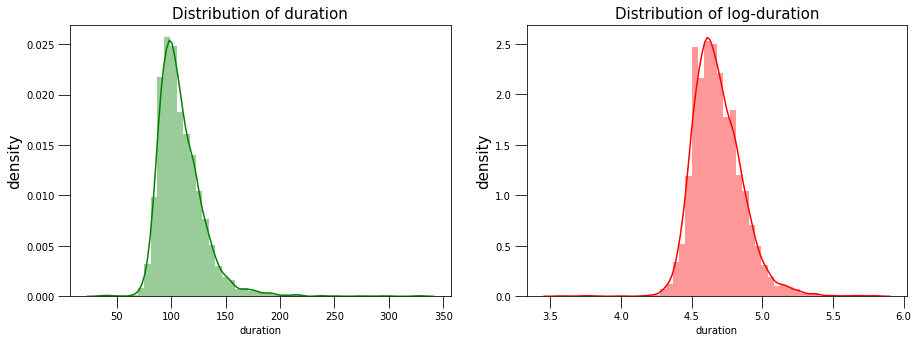

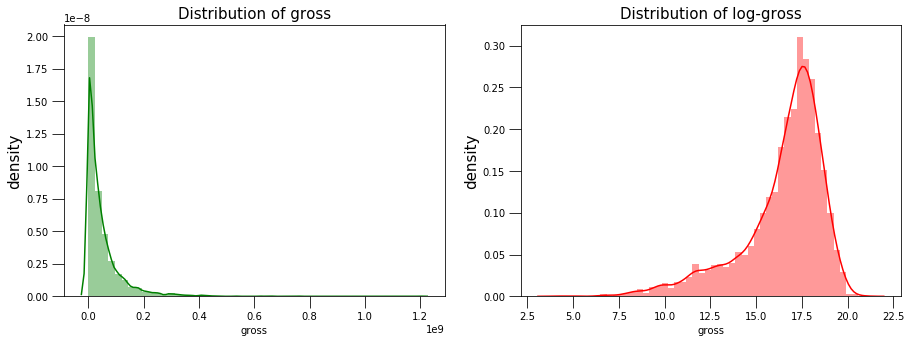

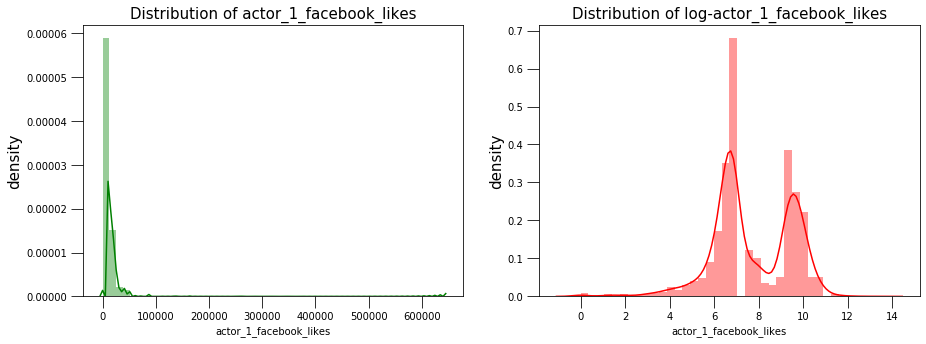

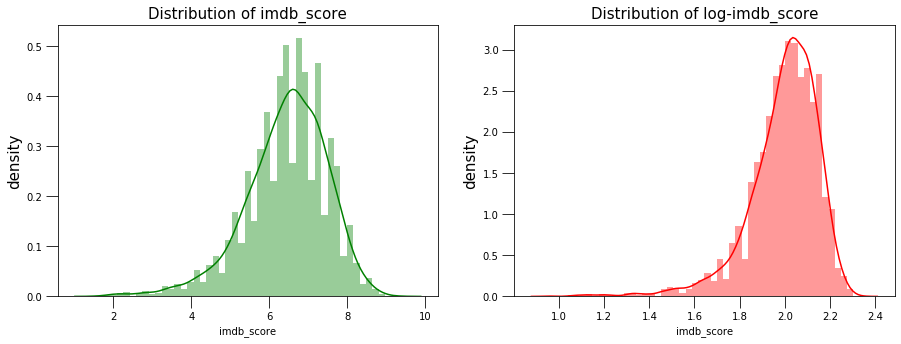

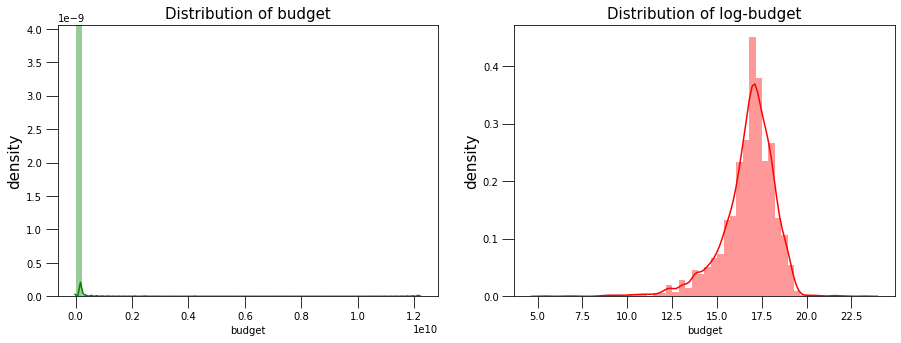

In [41]:
for col in ["duration", "gross", "actor_1_facebook_likes","imdb_score","budget"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(movie_df[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(movie_df[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

we can see that distribution of budget and gross of movies are not so explanatory. This is due to the fact the the data sets includes both boxoffice movies and documentaries that have a significant difference in marketing and financial needs.
So it might be interesting to look at the number of movies by genre. 


In [42]:
Count1 = movie_df.Genre_Group1.sum()
Count2 = movie_df.Genre_Group2.sum()
Count3 = movie_df.Genre_Group3.sum()
Count4 = movie_df.Genre_Group4.sum()
Count5 = movie_df.Genre_Group5.sum()
Count6 = movie_df.Genre_Group6.sum()
Count7 = movie_df.Genre_Group7.sum()
Count8 = movie_df.Genre_Group8.sum()
Count9 = movie_df.Genre_Group9.sum()
print('Action|Adventure =',Count1)
print('Comedy =',Count2)
print('Drama = ',Count3)
print('Mystery|Thriller|Horror =',Count4)
print('Animation =',Count5)
print('Crime =',Count6)
print('Sci-Fi|Superhero|Fantasy =',Count7)
print('Romance =',Count8)
print('Others =',Count9)

Action|Adventure = 1303
Comedy = 1558
Drama =  1980
Mystery|Thriller|Horror = 1349
Animation = 199
Crime = 715
Sci-Fi|Superhero|Fantasy = 916
Romance = 890
Others = 1191


Here we see that, half of the movies in the dataset have genre of drama. Comedy, (Mystery|Thriller|Horror), (Action|Adventure) follows the drama respectively.

In [43]:
print ("Percentages of the possible values for each single object \n")
movie_data = movie_df.select_dtypes(include=['O'])
for c in ['director_name','actor_1_name']:
    print ("Top 5 (Based on number of movie) %s" % c)
    print (movie_df[c].value_counts(normalize=True).head())
    print("\n")

Percentages of the possible values for each single object 

Top 5 (Based on number of movie) director_name
Steven Spielberg    0.005931
Clint Eastwood      0.004899
Woody Allen         0.004642
Martin Scorsese     0.004126
Ridley Scott        0.003868
Name: director_name, dtype: float64


Top 5 (Based on number of movie) actor_1_name
Robert De Niro       0.010572
Johnny Depp          0.009025
Nicolas Cage         0.007736
Matt Damon           0.007478
Denzel Washington    0.007478
Name: actor_1_name, dtype: float64




Here, we see that Steven Spielberg has the highest number of movies directed and Robert De Niro was the main actor at the movies more than all other actors.

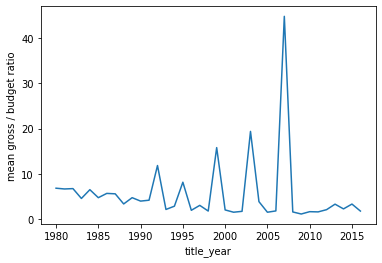

In [44]:
movie_df["gross_budget_ratio"] = movie_df.gross / movie_df.budget
grouped_by_year = movie_df.groupby("title_year").gross_budget_ratio.mean()
sns.lineplot(grouped_by_year.index, grouped_by_year)
plt.ylabel("mean gross / budget ratio")
plt.show()

In [45]:
ContentRating=movie_df.groupby('content_rating')['content_rating'].count()

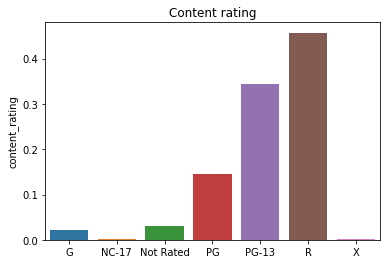

In [46]:
CRDF = ContentRating.to_frame()
units = CRDF.content_rating/CRDF.content_rating.sum()
bars = CRDF.index
names = np.arange(len(bars))
sns.barplot(names, units)
plt.xticks(names, bars)
plt.title("Content rating")
plt.show()

As can be seen above, half of the movies can be seen by people bigger than 13 years old (PG, PG-13, G). And remaining half can be watched by people above age of 17.

### 2. Let's look at films from a prominent director

In [47]:
director = "Steven Spielberg" # change this variable if you want to look into another director
director_films = movie_df.query(f"director_name == '{director}'").sort_values(by="title_year")
director_films.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,Genre_Group1,Genre_Group2,Genre_Group3,Genre_Group4,Genre_Group5,Genre_Group6,Genre_Group7,Genre_Group8,Genre_Group9,gross_budget_ratio
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0082971,Steven Spielberg,234.0,115.0,14000.0,488.0,Karen Allen,11000.0,242374454.0,Action|Adventure,Harrison Ford,...,1,0,0,0,0,0,0,0,0,13.465247
tt0083866,Steven Spielberg,215.0,120.0,14000.0,548.0,Dee Wallace,861.0,434949459.0,Family|Sci-Fi,Henry Thomas,...,0,0,0,0,0,0,1,0,1,41.423758
tt0087469,Steven Spielberg,148.0,118.0,14000.0,237.0,Amrish Puri,11000.0,179870271.0,Action|Adventure,Harrison Ford,...,1,0,0,0,0,0,0,0,0,6.423938
tt0088939,Steven Spielberg,70.0,154.0,14000.0,271.0,Rae Dawn Chong,852.0,94175854.0,Drama,Oprah Winfrey,...,0,0,1,0,0,0,0,0,0,6.278390
tt0097576,Steven Spielberg,149.0,127.0,14000.0,440.0,Julian Glover,11000.0,197171806.0,Action|Adventure|Fantasy,Harrison Ford,...,1,0,0,0,0,0,1,0,0,4.107746


Guys there is a function which do the one hot encoding :)

In [48]:

sums=director_films.sum()
print("Genres' counter\n")
for i in range(24,33):
    print('Group ',i-23,'=',sums[i])
    
print("\n")
print("Number of films per year \n")
print(director_films.title_year.value_counts())
print("\n")

Genres' counter

Group  1 = 13
Group  2 = 2
Group  3 = 11
Group  4 = 6
Group  5 = 0
Group  6 = 1
Group  7 = 10
Group  8 = 0
Group  9 = 12


Number of films per year 

1993.0    2
2011.0    2
2005.0    2
2002.0    2
1997.0    2
2016.0    1
1982.0    1
1984.0    1
1985.0    1
1989.0    1
1991.0    1
1998.0    1
2015.0    1
2001.0    1
2004.0    1
2008.0    1
2012.0    1
1981.0    1
Name: title_year, dtype: int64




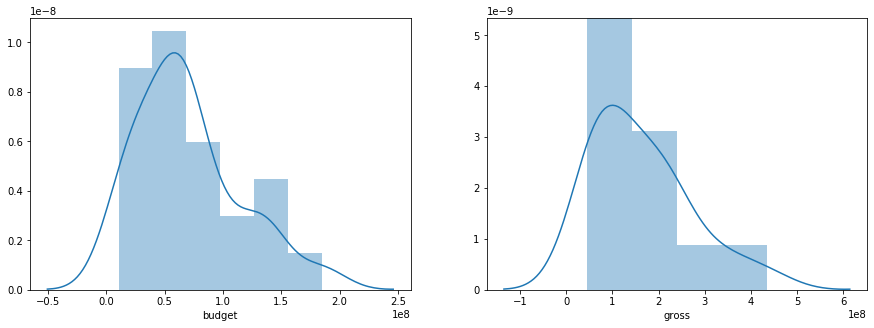

In [49]:
_, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
sns.distplot(director_films.budget, ax=ax1)
sns.distplot(director_films.gross, ax=ax2)
plt.show()

##### profitability - budget-gross ratio

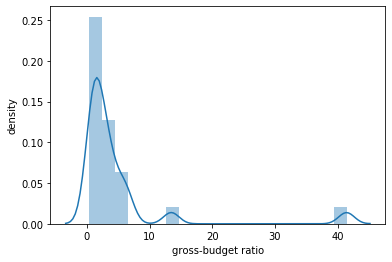

In [50]:
plt.figure()
sns.distplot(director_films["gross_budget_ratio"])
plt.xlabel("gross-budget ratio")
plt.ylabel("density")
plt.show()

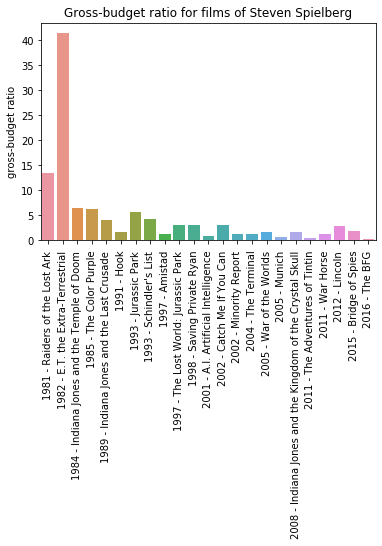

In [51]:
director_titles_years = director_films["title_year"].map(int).map(str) + " - " + director_films["movie_title"].map(str) 

sns.barplot(director_titles_years, director_films["gross_budget_ratio"])
plt.xticks(rotation=90)
plt.ylabel("gross-budget ratio")
plt.title(f"Gross-budget ratio for films of {director}")
plt.show()

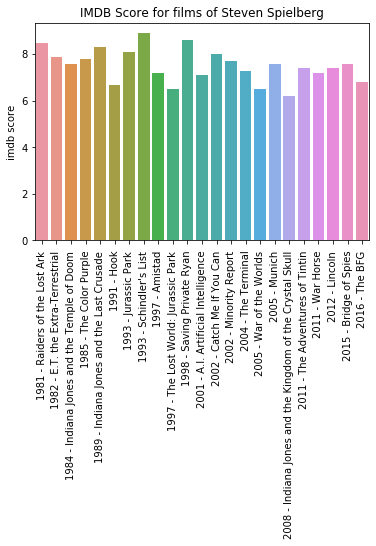

In [52]:
sns.barplot(director_titles_years, director_films.imdb_score)
plt.xticks(rotation=90)
plt.ylabel("imdb score")
plt.title(f"IMDB Score for films of {director}")
plt.show()

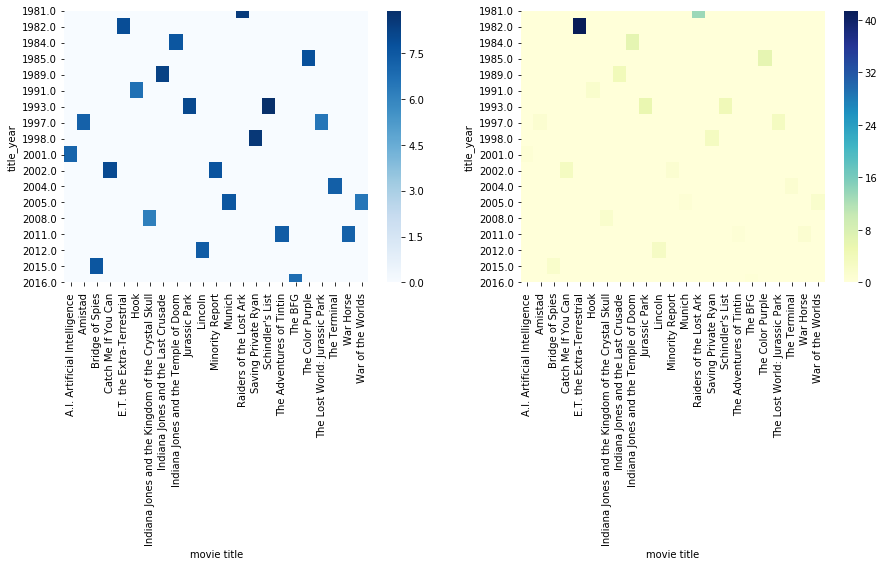

In [53]:
# heatmap 
_, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
director_film_year_score = pd.pivot_table(data=director_films, values=["imdb_score"], index=["title_year"],
                                          columns=["movie_title"]).fillna(0)

sns.heatmap(director_film_year_score, cmap="Blues", ax=ax1)
ax1.set_xticklabels(list(director_film_year_score.columns.levels[1]))
ax1.set_xlabel("movie title")

director_film_year_bgr = pd.pivot_table(data=director_films, values=["gross_budget_ratio"], index=["title_year"],
                                          columns=["movie_title"]).fillna(0)
sns.heatmap(director_film_year_bgr, cmap="YlGnBu", ax=ax2)
ax2.set_xticklabels(list(director_film_year_bgr.columns.levels[1]))
ax2.set_xlabel("movie title")

plt.show()
# I don't think we need this part, it gives the same information as above

## II. Bi/Multi-variate Analysis

With this analysis we want to find out the relationship between a factor with the two indicators of a film's success: profitability and IMDB score.



### 1. Relationship between profitability and IMDB score

In [54]:
movies_with_valid_profit = movie_df[movie_df.gross_budget_ratio<=20]

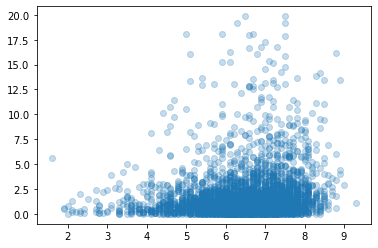

In [55]:
plt.scatter(movies_with_valid_profit.imdb_score, movies_with_valid_profit.gross_budget_ratio, alpha=.25)
plt.show()

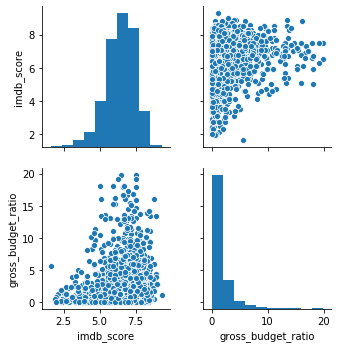

In [56]:
# again, don't see much influence here
sns.pairplot(data=movie_df[movie_df.gross_budget_ratio<=20], vars=["imdb_score", "gross_budget_ratio"]);

If we remove the outliers of profitability ratio, we see that to have a profitability ratio higher than 5, a movie must have an IMDb score of 4 and above.

In [57]:
movies_with_imdb_classmean=[]
movies_with_imdb_classmean.append(movie_df[(1<movie_df.imdb_score) & (movie_df.imdb_score<=2.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(2.5<movie_df.imdb_score) & (movie_df.imdb_score<=4) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(4<movie_df.imdb_score) & (movie_df.imdb_score<=5.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(5.5<movie_df.imdb_score) & (movie_df.imdb_score<=7) ].gross_budget_ratio.mean())
movies_with_imdb_classmean.append(movie_df[(7<movie_df.imdb_score) & (movie_df.imdb_score<=8.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(8.5<movie_df.imdb_score) & (movie_df.imdb_score<=10) ].gross_budget_ratio.mean()) 

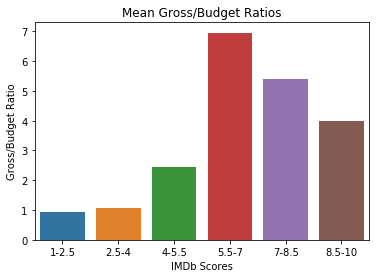

In [58]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean)
plt.xticks(rotation=0)
plt.ylabel("Gross/Budget Ratio")
plt.xlabel('IMDb Scores')
plt.title(f"Mean Gross/Budget Ratios")
plt.show()

In [59]:
movies_with_gb_classmean=[]
movies_with_gb_classmean.append(movie_df[(0<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=1) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(1<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=2.5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(2.5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=10) ].imdb_score.mean())
movies_with_gb_classmean.append(movie_df[(10<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=20) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(20<movie_df.gross_budget_ratio)].imdb_score.mean())

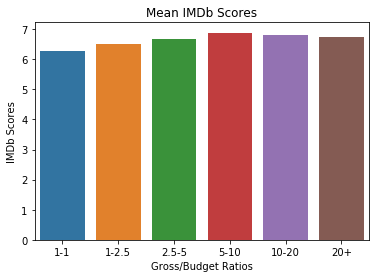

In [60]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean)
plt.xticks(rotation=0)
plt.ylabel("IMDb Scores")
plt.xlabel('Gross/Budget Ratios')
plt.title(f"Mean IMDb Scores")
plt.show()

### 2. Influence of Social Media?

In [61]:
movie_df.columns

Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'num_user_for_reviews',
       'language', 'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'movie_facebook_likes',
       'Genre_Group1', 'Genre_Group2', 'Genre_Group3', 'Genre_Group4',
       'Genre_Group5', 'Genre_Group6', 'Genre_Group7', 'Genre_Group8',
       'Genre_Group9', 'gross_budget_ratio'],
      dtype='object')

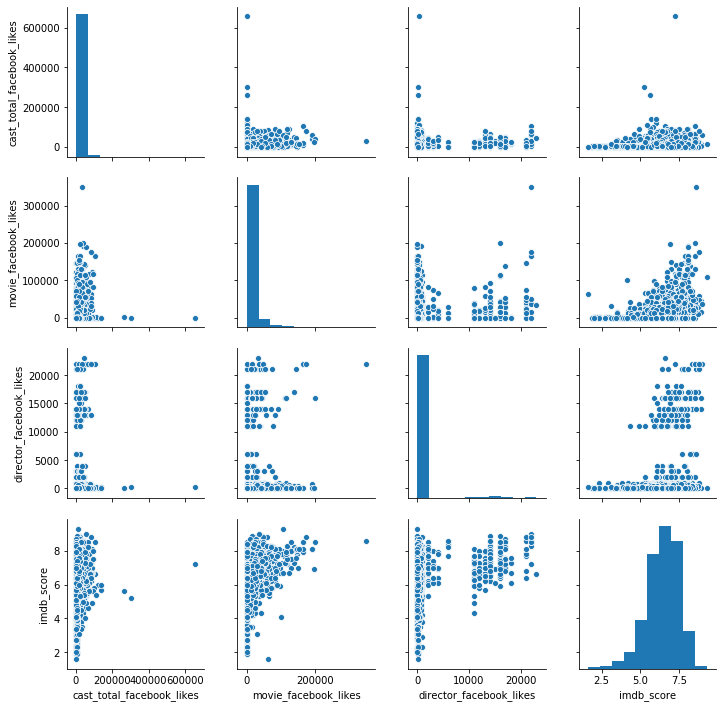

In [62]:
# we focus on cast's and director's total likes on facebook and movie_facebook_likes

# relation with imdb (NOTE: may want to take log of the social media likes because data is too skewed)

sns.pairplot(data=movie_df, vars=["cast_total_facebook_likes", "movie_facebook_likes", "director_facebook_likes",
                                           "imdb_score"]);

Here, we realize that IMDb score and movie facebook likes might be related. Hence, we analyze these two variables.

In [63]:
movies_with_imdb_classmean2=[]
movies_with_imdb_classmean2.append(movie_df[(1<movie_df.imdb_score) & (movie_df.imdb_score<=2.5) ].movie_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(movie_df[(2.5<movie_df.imdb_score) & (movie_df.imdb_score<=4) ].movie_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(movie_df[(4<movie_df.imdb_score) & (movie_df.imdb_score<=5.5) ].movie_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(movie_df[(5.5<movie_df.imdb_score) & (movie_df.imdb_score<=7) ].movie_facebook_likes.mean())
movies_with_imdb_classmean2.append(movie_df[(7<movie_df.imdb_score) & (movie_df.imdb_score<=8.5) ].movie_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(movie_df[(8.5<movie_df.imdb_score) & (movie_df.imdb_score<=10) ].movie_facebook_likes.mean()) 

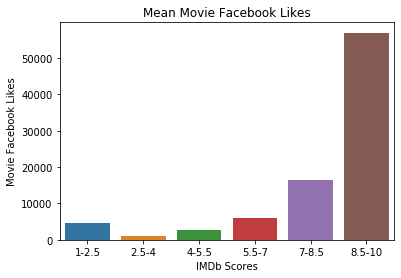

In [64]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("Movie Facebook Likes")
plt.xlabel('IMDb Scores')
plt.title(f"Mean Movie Facebook Likes")
plt.show()

Here, we see that as IMDb score increases, number of likes of the movie in Facebook increases.

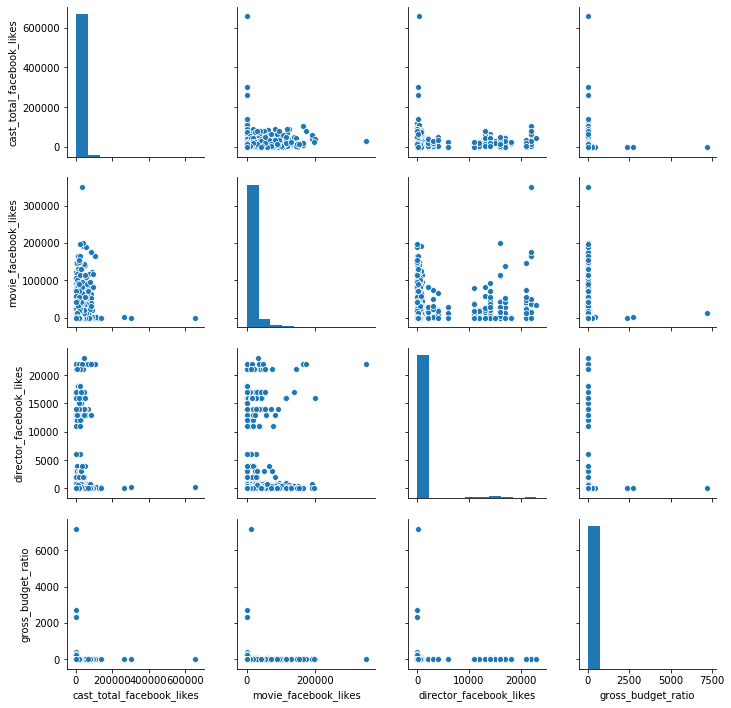

In [65]:
# again, don't see much influence here
sns.pairplot(data=movie_df, vars=["cast_total_facebook_likes", "movie_facebook_likes", 
                                                  "director_facebook_likes", "gross_budget_ratio"]);

### 3. Effect of Genre on Profitability and IMDb Score

### I. Profitability

In [66]:
GenreProf = movie_df[movie_df.gross_budget_ratio<=20].groupby(['Genre_Group1', 'Genre_Group2', 'Genre_Group3', 'Genre_Group4',
       'Genre_Group5', 'Genre_Group6', 'Genre_Group7', 'Genre_Group8',
       'Genre_Group9'])['gross_budget_ratio'].mean()
GenreNumber = movie_df[movie_df.gross_budget_ratio<=20].groupby(['Genre_Group1', 'Genre_Group2', 'Genre_Group3', 'Genre_Group4',
       'Genre_Group5', 'Genre_Group6', 'Genre_Group7', 'Genre_Group8',
       'Genre_Group9'])['gross_budget_ratio'].count()

In [67]:
Genrestable = GenreProf.to_frame()
Genrestable1 = Genrestable.reset_index()
Genrestable2 = Genrestable1.sort_values(by=['gross_budget_ratio'],ascending=False)

In [68]:
GenreNumber1 = GenreNumber.reset_index()
GenreNumber2 = GenreNumber1.reindex(Genrestable2.index)

In [69]:
Genrestable2

,Genre_Group1,Genre_Group2,Genre_Group3,Genre_Group4,Genre_Group5,Genre_Group6,Genre_Group7,Genre_Group8,Genre_Group9,gross_budget_ratio
143,1,0,1,0,1,0,0,0,1,9.395195
29,0,0,1,0,0,1,0,1,0,5.330340
178,1,1,0,0,1,1,0,0,0,5.255928
1,0,0,0,0,0,0,0,1,0,5.092133
195,1,1,1,0,0,0,0,1,1,4.724864
...,...,...,...,...,...,...,...,...,...,...
176,1,1,0,0,1,0,1,1,0,0.012798
95,0,1,1,0,1,1,0,0,1,0.007442
130,1,0,0,1,1,0,1,0,0,0.004519
131,1,0,0,1,1,0,1,0,1,0.000193


In [70]:
GenreNumber2

,Genre_Group1,Genre_Group2,Genre_Group3,Genre_Group4,Genre_Group5,Genre_Group6,Genre_Group7,Genre_Group8,Genre_Group9,gross_budget_ratio
143,1,0,1,0,1,0,0,0,1,1
29,0,0,1,0,0,1,0,1,0,3
178,1,1,0,0,1,1,0,0,0,1
1,0,0,0,0,0,0,0,1,0,1
195,1,1,1,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
176,1,1,0,0,1,0,1,1,0,1
95,0,1,1,0,1,1,0,0,1,1
130,1,0,0,1,1,0,1,0,0,1
131,1,0,0,1,1,0,1,0,1,1


From the 2 dataframe above, we see that 3 movies with genres Drama,Crime and Romance together achieved 5.3 gross/budget ratio. However, since number of movies are low it might be due to some outlier. Hence, we try to analyze highest number of movies with the same genre combination.

In [71]:
GenreNumber3=GenreNumber2.sort_values(by=['gross_budget_ratio'],ascending=False)
Genrestable3 = Genrestable2.reindex(GenreNumber3.index)

In [72]:
GenreNumber3

,Genre_Group1,Genre_Group2,Genre_Group3,Genre_Group4,Genre_Group5,Genre_Group6,Genre_Group7,Genre_Group8,Genre_Group9,gross_budget_ratio
20,0,0,1,0,0,0,0,0,1,219
80,0,1,1,0,0,0,0,1,0,160
19,0,0,1,0,0,0,0,0,0,156
78,0,1,1,0,0,0,0,0,0,154
49,0,1,0,0,0,0,0,0,0,151
...,...,...,...,...,...,...,...,...,...,...
91,0,1,1,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,1,1,1
35,0,0,1,0,1,0,1,0,1,1
156,1,0,1,1,0,1,1,1,1,1


In [73]:
Genrestable3

,Genre_Group1,Genre_Group2,Genre_Group3,Genre_Group4,Genre_Group5,Genre_Group6,Genre_Group7,Genre_Group8,Genre_Group9,gross_budget_ratio
20,0,0,1,0,0,0,0,0,1,1.681055
80,0,1,1,0,0,0,0,1,0,2.284800
19,0,0,1,0,0,0,0,0,0,1.789848
78,0,1,1,0,0,0,0,0,0,1.926130
49,0,1,0,0,0,0,0,0,0,2.017895
...,...,...,...,...,...,...,...,...,...,...
91,0,1,1,0,1,0,0,0,0,0.737079
2,0,0,0,0,0,0,0,1,1,0.694132
35,0,0,1,0,1,0,1,0,1,0.689250
156,1,0,1,1,0,1,1,1,1,0.687082


Here, we see that at the top 4 places all combinations have more than 140 movies. Hence, we can comment more confidently. We see that all of the for segments include Drama in it and all of them has gross/budget ratio of 2 which is a nice number for film makers. By looking at the data, we can say that:
1. Drama + Others ~ 1.7
2. Drama + Comedy + Romance ~2.4
3. Drama Only ~ 1.8
4. Drama + Comedy ~2

Hence, it might be logical to make a drama movie with some comedy and romance in it.

# Model Building for Profitability

# Model Building for IMDb Score

##### Getting data to be used in prediction to csv file

In [74]:
movie_df.to_csv('data/data_analysis.csv')